# Examine covid-19 variants

This examines covid-19 variants as originally aquired from <https://covid19.galaxyproject.org/genomics/4-Variation/>.

*Note:* This is being used to play around with data mining algorithms to see what we get. It's not necessarily the best way to process the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../original/variant_list.tsv.gz', sep="\t", low_memory=False)
print("%s rows x %s columns" % (data.shape[0], data.shape[1]))
data.head()

77121 rows x 14 columns


,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,EFF[*].IMPACT,EFF[*].FUNCLASS,EFF[*].EFFECT,EFF[*].GENE,EFF[*].CODON
0,SRR10903401,NC_045512,1409,C,T,126,0.039683,1,"67,54,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat
1,SRR10903401,NC_045512,1821,G,A,93,0.096774,0,"48,36,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt
2,SRR10903401,NC_045512,1895,G,A,106,0.037736,0,"51,51,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata
3,SRR10903401,NC_045512,2407,G,T,123,0.024390,0,"57,63,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG


Great. Let's look at the distribution of the `AF` column (alternative frequencies).

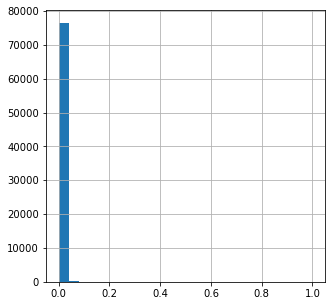

In [2]:
data['AF'].hist(figsize=(5,5), bins=25)

Hmmm... so almost all of the variants are low frequency (and maybe just errors). Let's look at higher frequency ones.

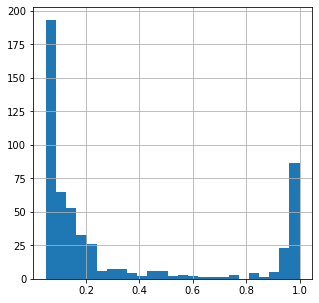

In [3]:
data[data['AF'] > 0.05]['AF'].hist(figsize=(5,5), bins=25)

Looks like a bit of a division between low and high (two peaks). What we'll do is split this data into two sets, the moderate frequency, and the ultra-low frequency (which may be mostly errors, but there's a lot more data there to apply data mining to).

Let's first create a new column with a variant ID to be used for later mining.

In [4]:
data['transaction_id'] = data.apply(
    lambda row: row.CHROM + ':' + row.REF + ':' + str(row.POS) + ':' + row.ALT, axis=1)
data

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,EFF[*].IMPACT,EFF[*].FUNCLASS,EFF[*].EFFECT,EFF[*].GENE,EFF[*].CODON,transaction_id
0,SRR10903401,NC_045512,1409,C,T,126,0.039683,1,"67,54,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat,NC_045512:C:1409:T
1,SRR10903401,NC_045512,1821,G,A,93,0.096774,0,"48,36,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt,NC_045512:G:1821:A
2,SRR10903401,NC_045512,1895,G,A,106,0.037736,0,"51,51,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata,NC_045512:G:1895:A
3,SRR10903401,NC_045512,2407,G,T,123,0.024390,0,"57,63,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT,NC_045512:G:2407:T
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG,NC_045512:A:3379:G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77116,SRR11410528,NC_045512,17934,C,T,1249,0.056045,7,"433,744,20,51",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,acC/acT,NC_045512:C:17934:T
77117,SRR11410528,NC_045512,23403,A,G,1684,0.988717,0,"0,0,380,1304",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,S,gAt/gGt,NC_045512:A:23403:G
77118,SRR11410528,NC_045512,25563,G,T,679,0.986745,0,"0,0,130,549",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,ORF3a,caG/caT,NC_045512:G:25563:T
77119,SRR11410528,NC_045512,26844,T,A,993,0.008056,35,"235,750,7,1",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,M,Tcc/Acc,NC_045512:T:26844:A


# Split into high and low frequency variants table

Let's split up this table into ultra-low, and moderate frequency variants (based on `AF` column).

In [5]:
data_mf = data[data['AF'] >= 0.05].copy()
data_ulf = data[data['AF'] < 0.05].copy()
print(f"Moderate frequency: {len(data_mf)}")
print(f"Ultra-low frequency: {len(data_ulf)}")

Moderate frequency: 542
Ultra-low frequency: 76579


We're going to first look at the low frequency variants.

# Define identifier of each transaction

The data is organized such that each genome name is an item, which are grouped into "transactions" based on the particular variant. We can group samples together based on shared SNVs (shared transaction IDs).

In [35]:
def group_transactions(df):
    f = df.groupby('transaction_id').agg(
        {'Sample': lambda x: set(x)}).reset_index().set_index('transaction_id')
    return pd.DataFrame(f['Sample'].values.tolist(), index=f.index)

transaction_table_mf = group_transactions(data_mf)
print(f"Size: {len(transaction_table_mf)}")
transaction_table_mf.head(5)

Size: 437


,0,1,2,3,4,5,6,7,8,9
transaction_id,,,,,,,,,,
NC_045512:A:10024:T,SRR11059942,None,None,None,None,None,None,None,None,None
NC_045512:A:10435:T,SRR11059942,None,None,None,None,None,None,None,None,None
NC_045512:A:10773:C,SRR11059943,None,None,None,None,None,None,None,None,None
NC_045512:A:10987:T,SRR11059942,None,None,None,None,None,None,None,None,None
NC_045512:A:11367:T,SRR10903402,SRR11059947,None,None,None,None,None,None,None,None


## Transaction table ultra-low

Let's also define the table of ultra-low frequency variants.

In [36]:
transaction_table_ulf = group_transactions(data_ulf)
print(f"Size: {len(transaction_table_ulf)}")
transaction_table_ulf.head(5)

Size: 31503


,0,1,2,3,4,5,6,7,8,9,10
transaction_id,,,,,,,,,,,
NC_045512:A:10005:G,SRR11059947,SRR11140748,SRR11059946,SRR11177792,None,None,None,None,None,None,None
NC_045512:A:10014:G,SRR11177792,SRR11059947,None,None,None,None,None,None,None,None,None
NC_045512:A:10017:G,SRR11177792,SRR11059946,None,None,None,None,None,None,None,None,None
NC_045512:A:10017:T,SRR11409417,SRR11393704,None,None,None,None,None,None,None,None,None
NC_045512:A:10018:G,SRR11177792,None,None,None,None,None,None,None,None,None,None


# Output variants table

Let's save the value of only data we are interested in so they can easily be loaded up later.

In [37]:
import csv

filename_mod = "moderate_frequency.tsv"
transaction_table_mf.to_csv(filename_mod, sep="\t", header=False, index=False)
print(f"Wrote to file {filename_mod}")

filename_ulf = "ultra_low_frequency.tsv"
transaction_table_ulf.to_csv(filename_ulf, sep="\t", header=False, index=False)
print(f"Wrote to file {filename_ulf}")

Wrote to file moderate_frequency.tsv
Wrote to file ultra_low_frequency.tsv
